In [37]:
#Load Packages
import cmasher           as cmr
import cartopy.crs       as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import pandas            as pd 
import regionmask        as rm
import warnings
import xarray            as xr
print("Packages Loaded")

Packages Loaded


In [38]:
#Set Working Directory
wd = '/Volumes/GoogleDrive/My Drive/zResearch/Manuscript/2021_HoloceneHydroclimate/2021_HoloceneHydroclimate'
os.chdir(wd)
print('Working wirectory set to: '+wd)

Working wirectory set to: /Volumes/GoogleDrive/My Drive/zResearch/Manuscript/2021_HoloceneHydroclimate/2021_HoloceneHydroclimate


In [100]:
#Load Model Data. TraCE & HadCM
modelData = {}
for model in ['hadcm','trace','cmip6']:
    modelData[model] = {}
    for szn in ['ANN','JJA','DJF']:
        if model == 'cmip6': end = '.nc'
        else: end =  '_regrid.nc'
        modelData[model][szn] = xr.open_dataset('Data/Model/'+model+'/'+model+'_'+szn+end,decode_times=False)
    print(model+" "+str(sorted([i for i in modelData[model][szn].data_vars]))+' loaded')
    
#Define ipcc region data
refReg     = rm.defined_regions.ar6.all
refRegLand = rm.defined_regions.ar6.land

hadcm ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
trace ['evp_regrid', 'p-e_regrid', 'pre_regrid', 'tas_regrid'] loaded
cmip6 ['evp', 'p-e', 'pre', 'tas'] loaded


In [152]:
#Plot Agreement Settings

#Model Data to Plot
szn       = 'ANN'
variables = ['pre','tas']

#Proxy Settings
n_thresh = 4 #minimum number of proxy records needed to plot on map

#True/False to save/not save
save = True 

#Plot Settings
plt.rcParams['font.family'   ] = 'Times New Roman'
plt.rcParams['axes.facecolor'] ='white'
plt.rcParams['axes.linewidth'] = 1; 
plt.rcParams['axes.edgecolor'] = 'k'

figSize = [6.5,4] # x,y in
orient = 'h' #vertical (v) or horizontal (h)

#Print summary
if save: print("Settings chosen to save "+szn+" "+str(variables))
else:    print("Settings chosen to plot "+szn+" "+str(variables))

Settings chosen to save ANN ['pre', 'tas']


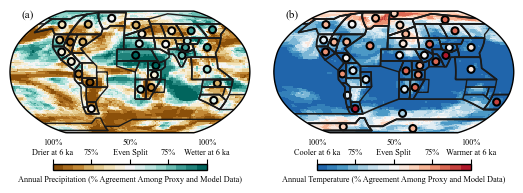

In [157]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(figSize[0],figSize[1]))
if orient == 'v': gs = gridspec.GridSpec(len(variables),1,hspace=0.1,wspace=0.1)
else:             gs = gridspec.GridSpec(1,len(variables),hspace=0.1,wspace=0.1)
for var in variables:
    #Position figure
    i  = [j for j,x in enumerate(variables) if x == var][0]
    if orient == 'v': ax = plt.subplot(gs[i:(i+1),0:1],projection=ccrs.Robinson())
    else:           ax = plt.subplot(gs[0:1,i:(i+1)],projection=ccrs.Robinson())
    #Set figure colors/labels based on climate Variable 
    if var == 'tas': 
        cramp, units, varname, n = 'RdBu_r','degC', 'Temperature', ['Cooler at 6 ka','Warmer at 6 ka']
        proxy = pd.read_csv('Data/proxy/proxyMetaData_T.csv')
    else:            
        cramp, units, varname, n = 'BrBG', 'mm/day', 'Precipitation', ['Drier at 6 ka','Wetter at 6 ka',]
        proxy = pd.read_csv('Data/proxy/proxyMetaData_HC.csv')
    #Calculate Proxy Percents for regions
    pRegs, pPcts, plats, plons = [],[],[],[]
    for reg in np.unique(proxy['ipccReg']): 
        #Filter proxy data for region
        regData = proxy.loc[proxy['ipccReg'] == reg] 
        if np.shape(regData)[0] < 4: continue
        #Calculate midHolocene anomalies
        direction = 2*((regData['direction'] != 'negative')-0.5)
        regData = (regData['ka_6']-regData['ka_0.5'])*direction
        if sum(~np.isnan(regData)) < 4: continue
        #Save region data
        pRegs.append(reg)
        pPcts.append(100*(sum(regData>0)/(sum(np.isnan(regData)==False)+sum(regData==0))))
        plats.append(refReg.centroids[refReg.abbrevs.index(reg)][1])
        plons.append(refReg.centroids[refReg.abbrevs.index(reg)][0])
    #Calculate sign of each gridcell and flatten into 2d
    modelVals = modelData['cmip6'][szn][var]
    modelN    = len(modelVals.model)
    modelAnom = np.sum(np.sign(modelVals),axis=0) 
    for model in ['hadcm','trace']:       
        modelVals = modelData[model][szn]
        modelVals = modelVals.rename({var+'_regrid':var,'lat_regrid':'lat','lon_regrid':'lon'})
        modelVals = modelVals[var].groupby_bins('time',[0,1000,5500,6500]).mean(dim="time")
        modelAnom += np.sign(modelVals[2,:,:]-modelVals[0,:,:])
        modelN +=1
    #Color bins based on model dimension
    cramp = cmr.get_sub_cmap(cramp,0.1,0.9,N=modelN+1)
    #Plot Data
    ax.annotate('('+list(map(chr, range(97, 123)))[i]+')',xy=(0, 0), xycoords='data', xytext=(0.05, 0.95), textcoords='axes fraction', fontsize=8, fontfamily = 'Times New Roman')
    refRegLand.plot_regions(ax=ax,add_label=False,line_kws=dict(linewidth=1))
    refReg[pRegs].plot_regions(ax=ax,add_label=False,line_kws=dict(linewidth=1.2))
    model_agree = plt.pcolormesh(modelVals.lon, modelVals.lat, (modelAnom/modelN)*100, cmap=cramp, vmin=-100, vmax=100, transform=ccrs.PlateCarree())
    ax.scatter(plons, plats, c=pPcts, cmap=cramp, s=25 ,ec='k', lw=1.5, vmin=0, vmax=100, transform=ccrs.PlateCarree())
    ax.set_global()
    #Color bar
    if orient == 'v': 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.04, pad=0.15,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (% Agreement Among Proxy and Model Data)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    else: 
        cbar = plt.colorbar(model_agree,orientation="horizontal",ticks=range(-100,101,50), fraction=0.02, pad=0.1,aspect=25)
        cbar.ax.set_xticklabels(['100%\n'+n[0],'75%','50%\nEven Split','75%','100%\n'+n[1]], fontsize=6, verticalalignment='baseline')
        cbar.ax.xaxis.set_ticks_position("top")    
        cbar.ax.text(0,-400,'Annual '+varname+' (% Agreement Among Proxy and Model Data)', horizontalalignment='center', verticalalignment='center',fontsize=6)
    
#Save/Plot
filename = 'midHoloceneAgreement_'
for var in variables: filename=filename+var+'_'
if save: plt.savefig('Figures/Model/Agreement/'+filename+szn+'.png', dpi=400,format='png', bbox_inches='tight')       
plt.show()
